# Dry Weather Patterns

Explore DWP during year 2016-2017

In [1]:
import datetime
import calendar
import json
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project and prepare data

In [2]:
project_folder = '../../datasets/thorium-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print(json.dumps(project, indent=4))
flow = pd.read_csv(project_folder + 'flow1_edited.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow_edited'].fillna(0)
flow = flow.resample('5T').pad()
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
flow_rain = pd.concat([flow, rainfall], axis=1).dropna()
flow_rain['day'] = flow_rain.index.map(lambda x: x.date())
flow_rain['month'] = flow_rain.index.map(lambda x: x.date().month)
print(flow_rain.head())
print(flow_rain.tail())

{
    "end-date": "2017-12-31",
    "flows": [
        "flow1"
    ],
    "name": "thorium-medium",
    "rainfalls": [
        "rainfall1"
    ],
    "split-date": "2017-01-01",
    "start-date": "2015-06-02"
}
                     flow_edited  rainfall         day  month
time                                                         
2015-06-01 14:15:00   115.559998       0.0  2015-06-01      6
2015-06-01 14:20:00   115.199997       0.0  2015-06-01      6
2015-06-01 14:25:00   112.209999       0.0  2015-06-01      6
2015-06-01 14:30:00   112.860001       0.0  2015-06-01      6
2015-06-01 14:35:00   113.349998       0.0  2015-06-01      6
                     flow_edited  rainfall         day  month
time                                                         
2018-03-31 23:35:00   100.839996       0.0  2018-03-31      3
2018-03-31 23:40:00    98.599998       0.0  2018-03-31      3
2018-03-31 23:45:00    97.250000       0.0  2018-03-31      3
2018-03-31 23:50:00    96.160004       0.0  2

# Find Dry days

In [33]:
flow_rain['precipitation_24h'] = flow_rain.rainfall.rolling(24*12).sum()
df = flow_rain.groupby(by=flow_rain.day).precipitation_24h.sum()
df = df[df < 0.1].reset_index()
dry_days = set(df.day)
print('Found {} days'.format(len(dry_days)))

Found 476 days


# Dry Weather Pattern

Dry Weather Pattern is daily flow when we know that there was no precipitation at least 8h before this day and during this day

## Mean DWP

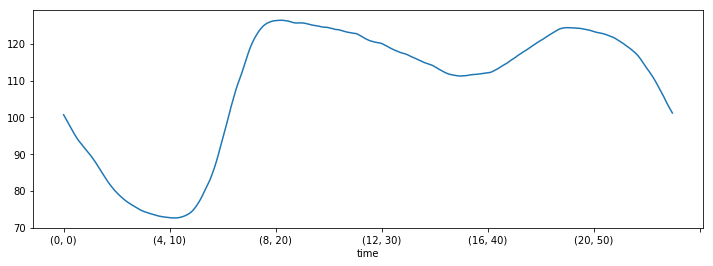

In [40]:
df = flow_rain['2016-01-01':]
df_dry_days = df[df.day.isin(dry_days)]
df = df_dry_days.reset_index()
daily_pattern = df.groupby(by=[df.time.map(lambda x : (x.hour, x.minute))]).flow_edited.mean()
daily_pattern.plot()
plt.show()

## How the DWP changes during the year

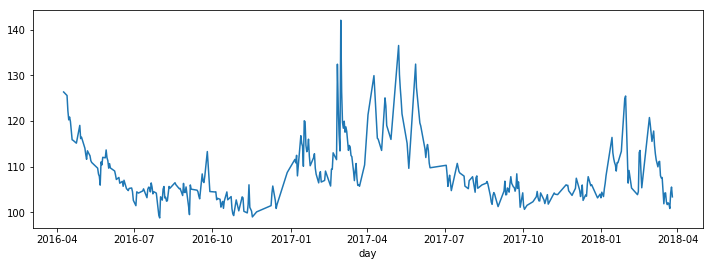

In [43]:
df = df_dry_days['2016-01-01':].groupby(by=['day']).flow_edited.mean()
df.plot()
plt.show()

### Zoom to the peaks

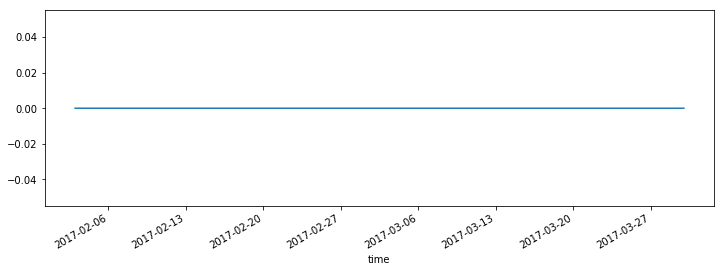

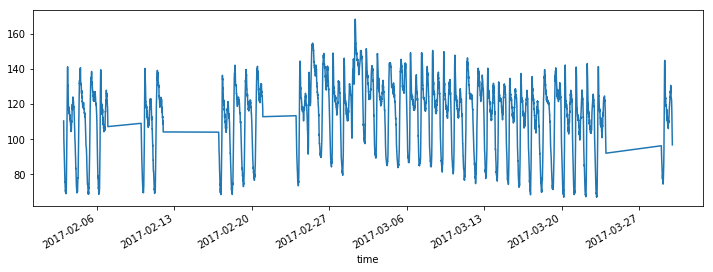

In [48]:
df = df_dry_days['2017-02-01':'2017-04-01']
df.rainfall.plot()
plt.show()
df.flow_edited.plot()
plt.show()

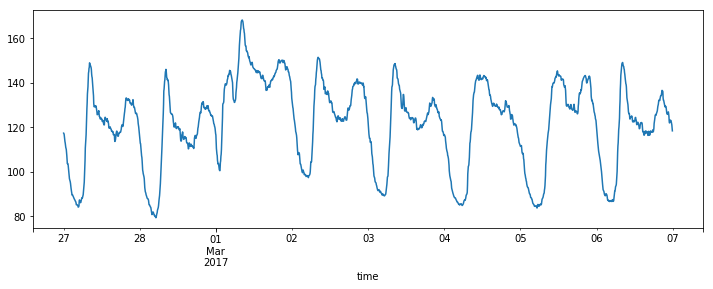

In [50]:
df = df_dry_days['2017-02-27':'2017-03-06']
df.flow_edited.plot()
plt.show()

### Explore 2017-03-01

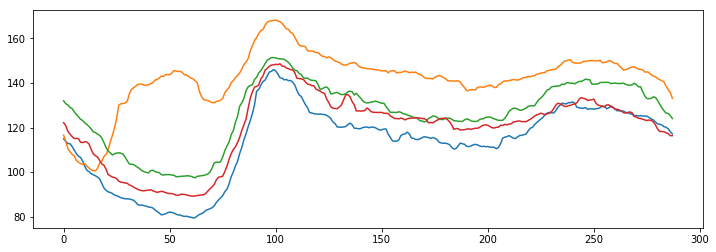

In [58]:
df = df_dry_days['2017-02-28':'2017-02-28'].reset_index()
df.flow_edited.plot()
df = df_dry_days['2017-03-01':'2017-03-01'].reset_index()
df.flow_edited.plot()
df = df_dry_days['2017-03-02':'2017-03-02'].reset_index()
df.flow_edited.plot()
df = df_dry_days['2017-03-03':'2017-03-03'].reset_index()
df.flow_edited.plot()
plt.show()

## Explore peaks

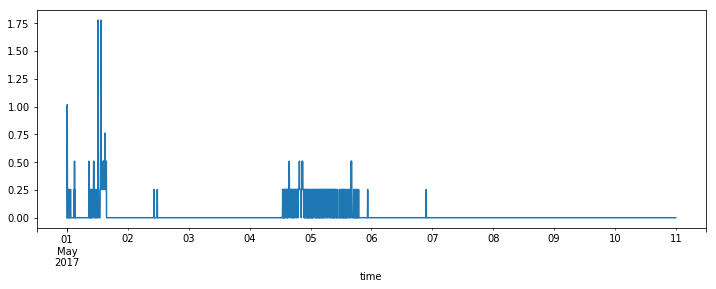

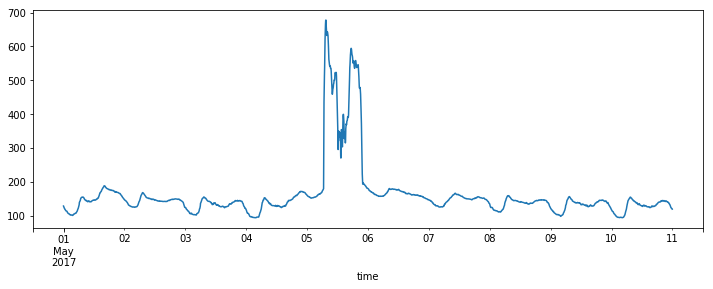

In [10]:
df = flow_rain['2017-05-01':'2017-05-10']
df.rainfall.plot()
plt.show()
df.flow_edited.plot()
plt.show()

## Add inflow data based on daily pattern

In [39]:
def inflow(row):
    pattern_idx = (row.name.hour, row.name.minute)
    pattern_value = daily_pattern[pattern_idx]
    return row.flow - pattern_value


flow_rain['inflow'] = flow_rain.apply(inflow, axis=1)
flow_rain.tail()

,flow,rainfall,precipitation_1h,precipitation_2h,precipitation_4h,precipitation_8h,inflow
time,,,,,,,
2017-11-10 14:20:00,107.830002,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-4.900445
2017-11-10 14:25:00,107.459999,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-5.079138
2017-11-10 14:30:00,106.919998,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-5.460512
2017-11-10 14:35:00,105.559998,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-6.519046
2017-11-10 14:40:00,104.940002,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-6.870444


# Check rainfall - inflow correlation

## Check 1 hour precipitation correlation

y = 4.269x + -1.845


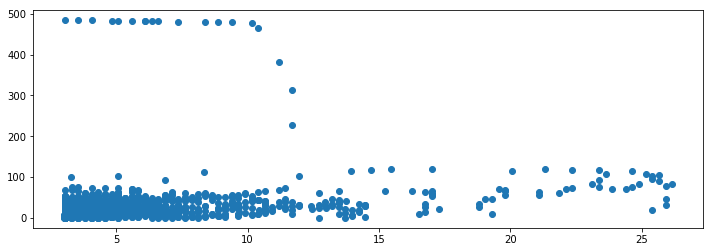

In [75]:
df = flow_rain[(flow_rain.precipitation_1h > 3) & (flow_rain.inflow < 2000) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_1h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_1h, df.inflow)
plt.show()

## Check 2 hours precipitation correlation

y = 3.277x + -8.635


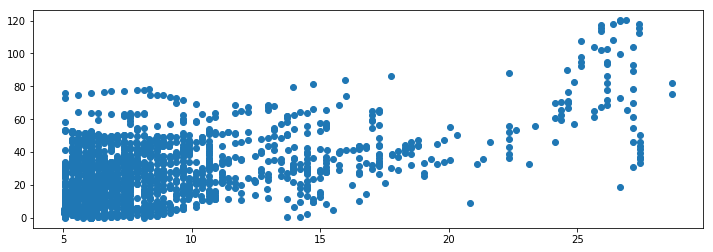

In [68]:
df = flow_rain[(flow_rain.precipitation_2h > 5) & (flow_rain.inflow < 200) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_2h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_2h, df.inflow)
plt.show()

## Check 4 hours precipitation correlation

y = 0.7837x + 4.13


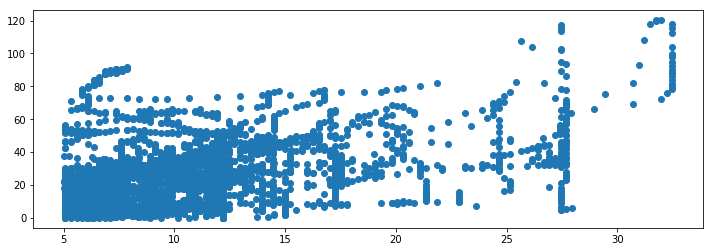

In [57]:
df = flow_rain[(flow_rain.precipitation_4h > 5) & (flow_rain.inflow < 150) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_4h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_4h, df.inflow)
plt.show()

## Check 8 hours precipitation correlation

y = -0.3438x + 21.65


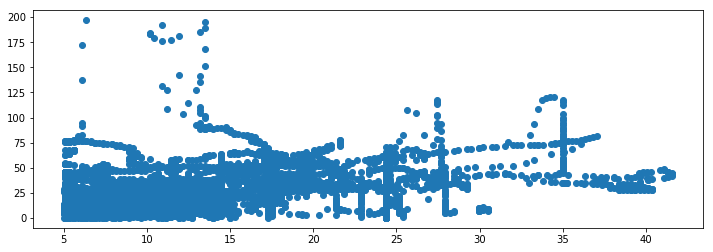

In [58]:
df = flow_rain[(flow_rain.precipitation_8h > 5) & (flow_rain.inflow < 200) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_8h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_8h, df.inflow)
plt.show()

# Analysis of days with very high inflow

In [89]:
set(flow_rain[flow_rain.inflow > 300].index.date)

{datetime.date(2017, 5, 5), datetime.date(2017, 5, 25)}

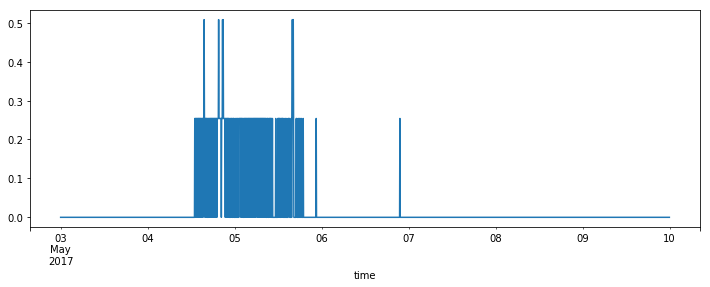

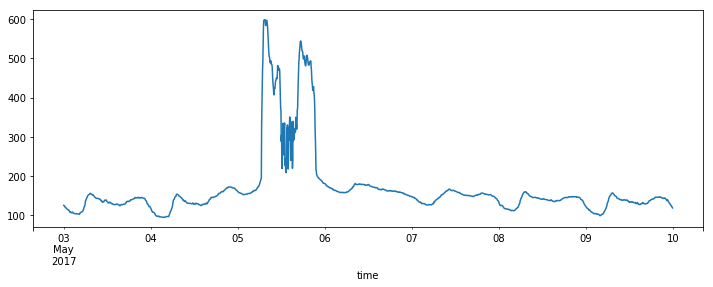

In [95]:
df = flow_rain['2017-05-03': '2017-05-09']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()

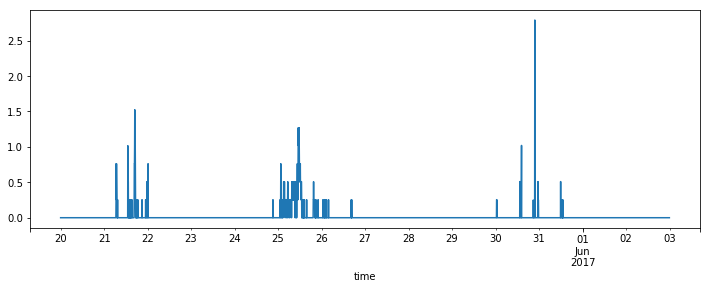

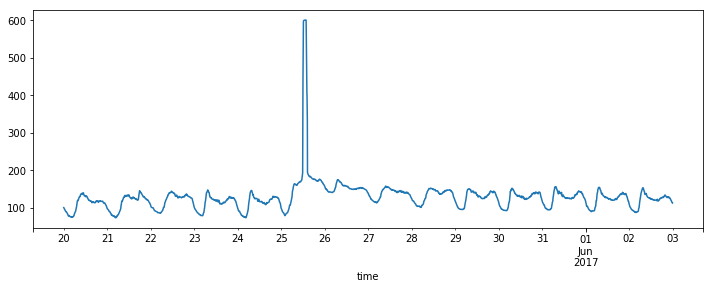

In [97]:
df = flow_rain['2017-05-20': '2017-06-02']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()